# Image Classification

In [2]:
#Import Libraries
import os
import cv2
import datetime
import imghdr
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [3]:
PATH = os.getcwd()

LOG_PATH = os.path.join(PATH,'log')
MODEL_SAVE_PATH = os.path.join(PATH,'model',"model.h5")

### Remove Dodgy Images

In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e :
            print("Issue with iamge {}".format(image_path))

### Load Data

In [7]:
data = keras.utils.image_dataset_from_directory('data')

Found 40000 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

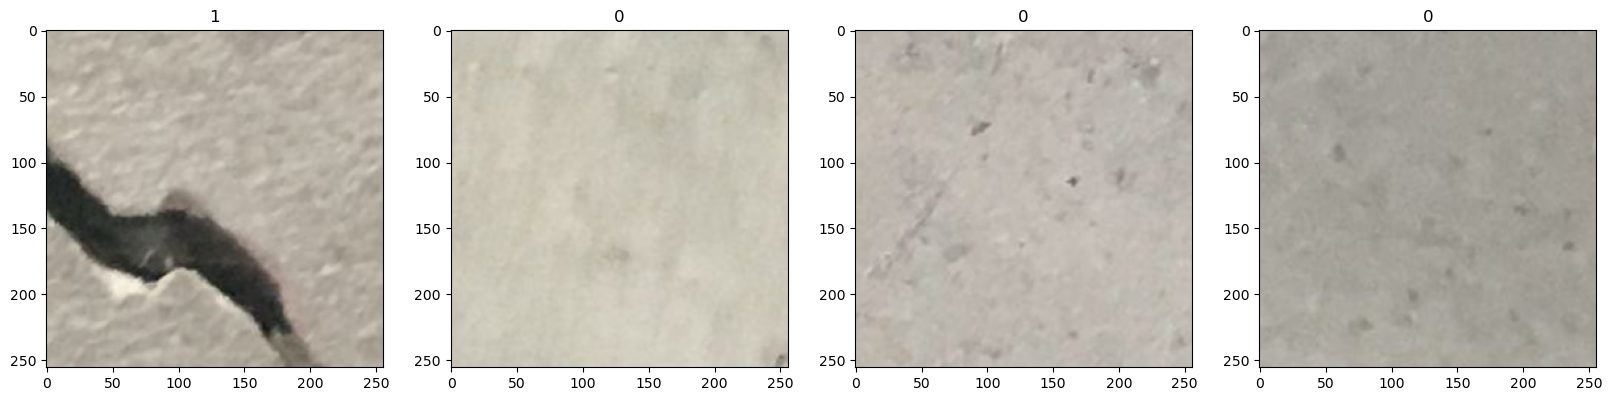

In [10]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Scale Data

In [11]:
data = data.map(lambda x,y: (x/255,y))

In [12]:
data.as_numpy_iterator().next()

(array([[[[0.5882353 , 0.5921569 , 0.57254905],
          [0.5882353 , 0.5921569 , 0.57254905],
          [0.5938572 , 0.5977788 , 0.57817096],
          ...,
          [0.7535999 , 0.75752145, 0.736803  ],
          [0.7201593 , 0.72408086, 0.70055145],
          [0.69411767, 0.69803923, 0.6745098 ]],
 
         [[0.5914905 , 0.5954121 , 0.57580423],
          [0.58878845, 0.59271   , 0.5731022 ],
          [0.58919054, 0.5931121 , 0.57350427],
          ...,
          [0.7894072 , 0.79332876, 0.7726103 ],
          [0.7554135 , 0.75933504, 0.73580563],
          [0.7266697 , 0.7305913 , 0.7070619 ]],
 
         [[0.6034007 , 0.6073223 , 0.58771443],
          [0.5978122 , 0.60173374, 0.5821259 ],
          [0.59263843, 0.59656   , 0.57695216],
          ...,
          [0.7911152 , 0.7950368 , 0.77431834],
          [0.75700825, 0.7609298 , 0.7374004 ],
          [0.7277114 , 0.73163295, 0.70810354]],
 
         ...,
 
         [[0.64928   , 0.6532016 , 0.63359374],
          [0.67347

### Split Data

In [13]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) # for tuning parameters like number of hidden layers/picking the best model
test_size = int(len(data)*.1) #solely for getting the performance of the model

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Building the Model

In [15]:

model = Sequential()
model.add(Conv2D(16,(3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

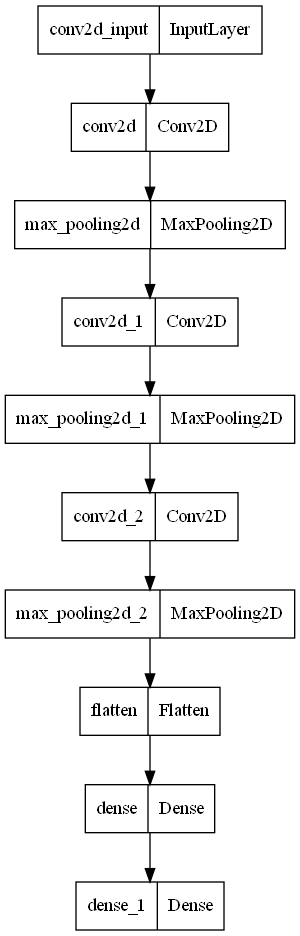

In [17]:
model.summary()
keras.utils.plot_model(model)

### Train

In [18]:
log_dir = os.path.join(LOG_PATH, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
early_stopping = keras.callbacks.EarlyStopping(patience=3)
epochs = 20

In [20]:
hist = model.fit(train, epochs=epochs, validation_data=val, batch_size=800,callbacks=[early_stopping, tb])

Epoch 1/20
875/875 [==============================] - 47s 50ms/step - loss: 0.1358 - accuracy: 0.9513 - val_loss: 0.0645 - val_accuracy: 0.9840
Epoch 2/20
875/875 [==============================] - 44s 50ms/step - loss: 0.0599 - accuracy: 0.9812 - val_loss: 0.0697 - val_accuracy: 0.9770
Epoch 3/20
875/875 [==============================] - 46s 52ms/step - loss: 0.0508 - accuracy: 0.9850 - val_loss: 0.0447 - val_accuracy: 0.9925
Epoch 4/20
875/875 [==============================] - 46s 52ms/step - loss: 0.0422 - accuracy: 0.9875 - val_loss: 0.0311 - val_accuracy: 0.9895
Epoch 5/20
875/875 [==============================] - 45s 51ms/step - loss: 0.0240 - accuracy: 0.9929 - val_loss: 0.0211 - val_accuracy: 0.9949
Epoch 6/20
875/875 [==============================] - 45s 52ms/step - loss: 0.0205 - accuracy: 0.9935 - val_loss: 0.0366 - val_accuracy: 0.9910
Epoch 7/20
875/875 [==============================] - 45s 52ms/step - loss: 0.0323 - accuracy: 0.9910 - val_loss: 0.0221 - val_accuracy:

### Plot the Performance

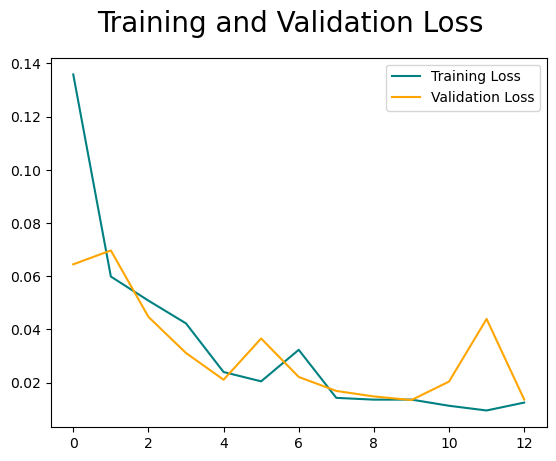

In [21]:

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Training and Validation Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

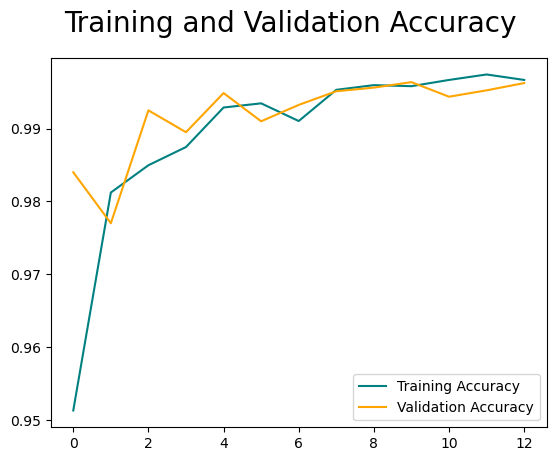

In [22]:

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Training and Validation Accuracy', fontsize=20)
plt.legend(loc='lower right')
plt.show()

### Evaluate

In [23]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [24]:
for batch in test.as_numpy_iterator():
    X,y = batch
    pred = model.predict(X)
    pre.update_state(y,pred)
    re.update_state(y,pred)
    acc.update_state(y,pred)

1/1 [==============================] - 0s 30ms/step


In [25]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

0.99701047 0.99601793 0.9965


### Save the Model

In [26]:
keras.models.save_model(model,MODEL_SAVE_PATH)

### Deploy the Model to Make Prediction

In [27]:
load_model = load_model('./model/model.h5')

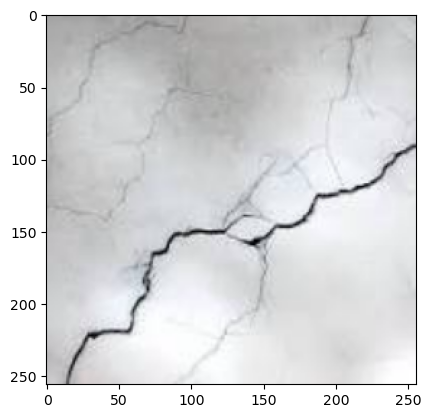

In [28]:
test = cv2.imread('./Test Data/Test Data 1.jpeg') 
resize = tf.image.resize(test, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [29]:
y_pred = load_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 291ms/step


In [30]:
if y_pred > 0.5:
    print(f'Predicted class is Positive')
else:
    print(f'Predicted class is Negative')

Predicted class is Positive
